## Finite population dynamics

The diversity of life on Earth that we observe today is the result of evolution, which has taken place within finite populations, in conditions of limited resources.

To develop intuitions about this evolutionary process, we want to study various scenarios in an object-oriented simulation.

Think about the objects that you may use. At the minimum, we would have to represent:
- **Individual** - characterized primarily by its genome, i.e. a string of nucleotides (A, C, G, T). Should be able to make a copy of itself, potentially imperfect copy (with mutations).
- **Population** - composed of all individuals that are "alive" at a given time. We should be able to initialize the population in various ways, as well as evolve it in a various ways. One scenario, at which we will also look in the lecture, is replicating the population generation by generation, creating a new generation by sampling, with replacement, and replicating individuals from the old generation.

The implementation should allow us to ask questions like the following:
1. What is the trace of ancestors of an individual in the current population?
2. How many generations ago did two individuals have a common ancestor?
3. How long ago did **all** individuals from the current generation have a common ancestor?
4. What is the genetic distance between two individuals in the current population?
5. What is the relationship between the population size and the time to the most recent common ancestor?


In [36]:
import os, sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'population_dynamics'))
from population import Population  # jupyter import bug, is fine
# from individual import Individual  # jupyter import bug, is fine
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import stats

In [37]:
# Set population parameters and initialize
initial_size = 10
genome_length = 50
mutation_rate = 0.01

# Initialize population
my_pop = Population(initial_size, genome_length, mutation_rate)
print(str(my_pop))

Generation #0, Population size: 10
Individual #0, 87d747: CACGAATGCAAGCTTAGCGTTTCCTATGTGTGTCTAGCCGAACCCGGTTT
Individual #1, 88c00b: GATGTTGGGTATATACTACTAGGGTGTCTTTGCAAGCCTGCATGGCCTGT
Individual #2, 47afcf: GACGACCTACTTCCCGAAGGATGGTAATTAGCGGGCGCTGGCTATGAATT
Individual #3, f7535c: TAAGCTCCAGCAACCGGGTGTTGTCGGAGAGGGCCAAATCGAGCAAAGAA
Individual #4, 22e045: TCAGTGTTGCCACTCGGTTCGGTAGGTCCGGCCTAGGTGTATGGGCTCAG
Individual #5, b2372e: GCAACTTCCTAAATGATGGGCGATCTAACAGCCGCAGGCTCGTAAAGCTG
Individual #6, aa9abb: CGTCACAGTCGTCCACCACGACAAGCAGGCCAGGGTTAGTGCCATCGAGA
Individual #7, 2976a7: AAGGCACATATCATTGCTATACTCTCAATAGACTTATGGAGCATCTTCAA
Individual #8, 3716e2: CTCCGCAAAGCCAGGCGCGGTCCATATATCGACACCCTAATTCGTGTCAG
Individual #9, 1e370c: GTTGTAGGAGGTCTCCATACATATCGCATTTCCTAGCATATAATTACTTA


In [38]:
# Evolve population in iterative steps
number_of_generations = 25
print("Evolving for " + str(number_of_generations) + " generations")
for p_i in range(number_of_generations):
    my_pop.get_next_generation()

print(str(my_pop))

Evolving for 25 generations
Generation #25, Population size: 10
Individual #0, 02cfe4: TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
Individual #1, 9bec8e: TTTGTAGGAACTCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
Individual #2, 9078e0: GTTGTAGGAAATCTCCATAGACATCGCTTTTCCCAGCGTATAATTACTTA
Individual #3, d70f8e: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCTAGCGGATAATTACTTA
Individual #4, cd97e2: GTTGTAGGAAATCTCCATAGACATCGCTTTTCCCAGCGTATAATTACTTA
Individual #5, 139b0f: GTTGTAGGAAATCTCCATAGACATCGCTTTTCCCAGCGTATAATTACTTA
Individual #6, 9e7b20: GTTGTATGAAATGTCCATAGATATCGCGTGTCCCAGCGTATAATTACTTA
Individual #7, 6c627a: GTTGTATGAAATGTCCATAGATATCGCGTGTCCCAGCGTATAATTACTTA
Individual #8, f71f49: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCTAGCGGATAATTACTTA
Individual #9, 865eca: TTTGTAGGAACTCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA


In [39]:
# Check all unique individual genomes in population
all_genomes = my_pop.get_all_individual_genomes()
unique_genomes = list(set(genome for genome in all_genomes))
print("Number of unique genomes in population: " + str(len(unique_genomes)))
for genome in unique_genomes:
    print("Genome: " + str(genome) + ", count: " + str(all_genomes.count(genome)))

Number of unique genomes in population: 83
Genome: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCCAGCGGATAATTACTTA, count: 25
Genome: GTTGTAGGAAATCTCCATATATATCGCTTTTCCCAGCGTATAATTACTTA, count: 2
Genome: GTTGTAGGAGATCTCCAGACATATCGCTTTTCCCAGCGTATTATTACTTA, count: 1
Genome: GCAACTTCCTAAATGATGGGCGATCTAACAGCCGCAGGCTCGTACGGCTG, count: 1
Genome: GCAACTTCCTAAATGATGGGCGATCTAACAGCCGCAGGCTCGTACAGCTG, count: 5
Genome: GTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA, count: 3
Genome: GTTGTAGGAAATCTCCAAAGATATCGCGTGTCCCAGCGTATAATTACTTA, count: 1
Genome: GTTGTCGGAAATCTCCATAGATATCGCTTTTCCCAGCGTATAATTACTTA, count: 1
Genome: GCAACTTACTAAATGATGGGCGATCTAACAGCCGCAGGCTCGTACCGCTG, count: 2
Genome: TTTGTAGGAACTCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA, count: 5
Genome: GACGACCTACTTCCCGAAGGATGGTAATTAGCGGGCGCTGGCTATGGATT, count: 2
Genome: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCCAGCGTATAATGACATA, count: 1
Genome: GTTGTAGGAGATCTCCATACATATCGCTTTTCCCAGCGTATTATTACTTA, count: 2
Genome: GTTGTAGGAAAGCTCCATAGATATCGCGTTTCCCAGCGGATAATTACTTA,

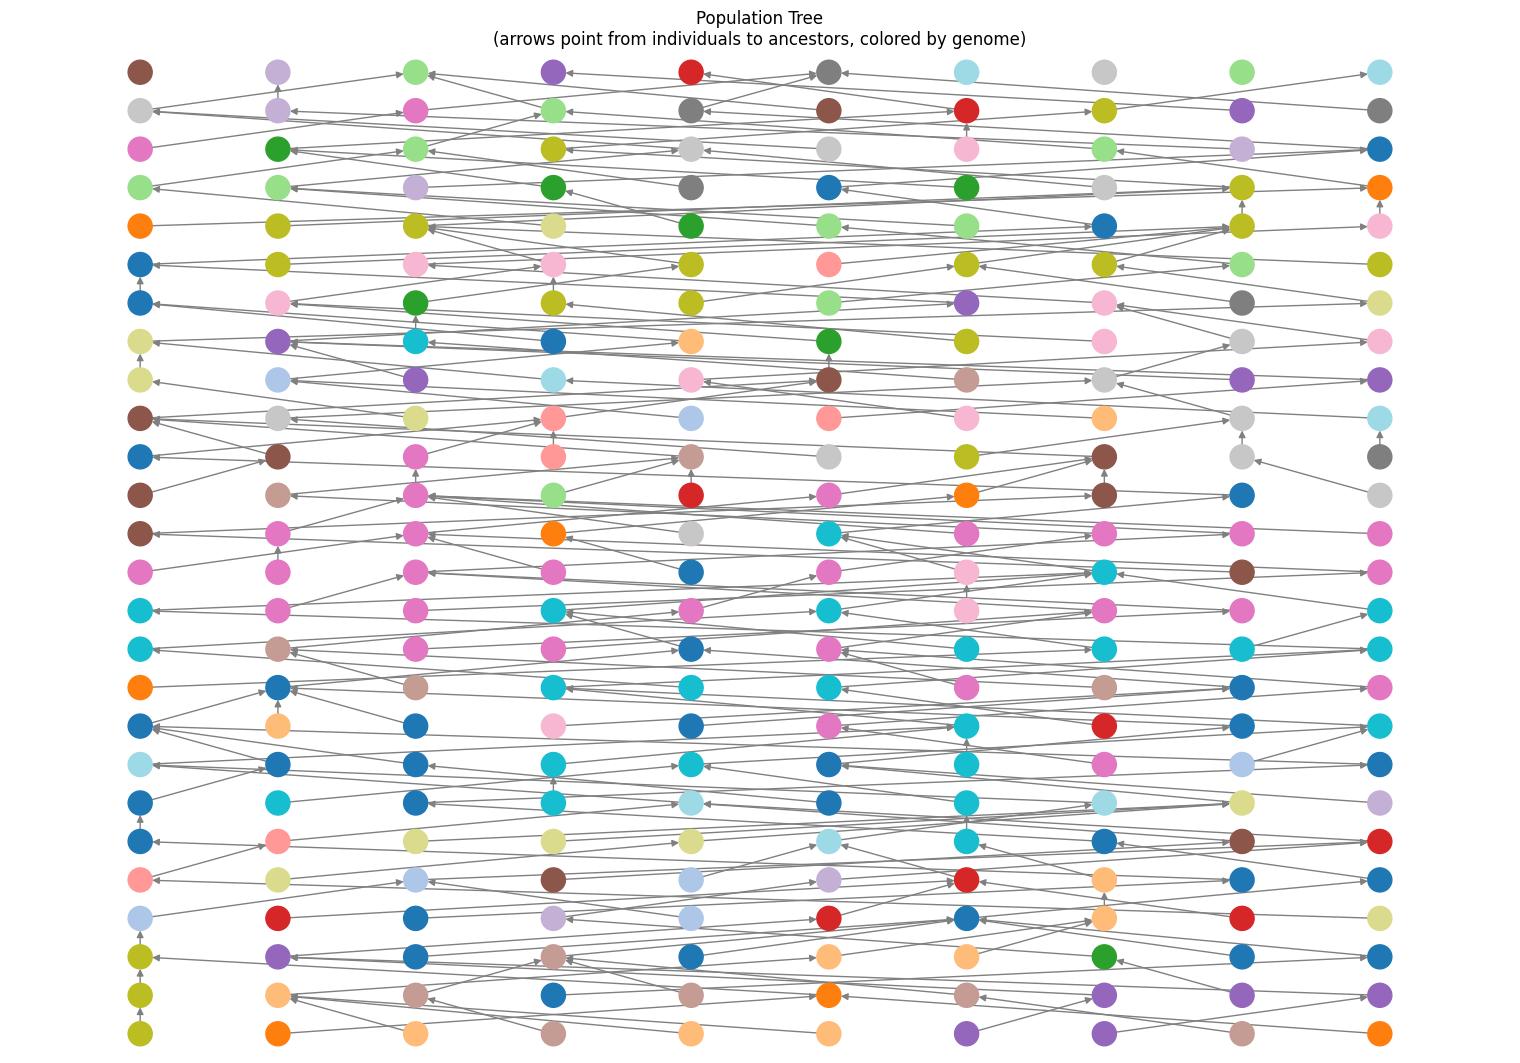

In [40]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes for all individuals in all generations
positions = {}

# Store node colors
node_colors = {}

# Create a color mapping for unique genomes
unique_genomes = list(set(genome for genome in my_pop.get_all_individual_genomes()))
color_map = plt.get_cmap('tab20')  # Use tab20 for up to 20 distinct colors
genome_color_dict = {genome: color_map(i/len(unique_genomes)) 
                        for i, genome in enumerate(unique_genomes)}

for gen_idx, generation in enumerate(my_pop.generations):
    y_pos = -gen_idx  # Negative to have first generation at top
    for ind_idx, individual in enumerate(generation):
        # Use individual's ID as node identifier
        node_id = individual.id
        G.add_node(node_id)
        # Position nodes in a row for each generation
        x_pos = (ind_idx - len(generation)/2) / len(generation)  # Center individuals horizontally
        positions[node_id] = (x_pos, y_pos)
        # Assign color based on genome
        node_colors[individual.id] = genome_color_dict.get(individual.genome, 'black')

# Add edges (arrows) from individuals to their parents
for gen_idx, generation in enumerate(my_pop.generations[1:], 1):  # Start from second generation
    for individual in generation:
        if hasattr(individual, 'parent') and individual.parent:
            G.add_edge(individual.id, individual.parent.id)

# Extract color list in the same order as nodes
colors = [node_colors.get(node, 'gray') for node in G.nodes()]

# Create the plot
plt.figure(figsize=(15, 10))
nx.draw(G, pos=positions, 
        node_size=300,
        node_color=colors,
        edge_color='gray',
        arrowsize=10,
        with_labels=False)

# Add generation labels on the y-axis
plt.ylim(-(len(my_pop.generations)-0.5), 0.5)
plt.title('Population Tree\n(arrows point from individuals to ancestors, colored by genome)')
plt.show()

In [41]:
del positions, y_pos, x_pos

In [42]:
# Print ancestor trace of a given individual
individual_index = 0
my_pop.individuals[individual_index].print_ancestor_tree()

Ancestor tree for Individual 02cfe4:
0. Self: 02cfe4 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
1. Parent: 62e93c - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
2. Gen -2: d61e26 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
3. Gen -3: 335327 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
4. Gen -4: fe8369 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
5. Gen -5: 1f5e18 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
6. Gen -6: 8860a5 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
7. Gen -7: 267ec1 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
8. Gen -8: de52d8 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
9. Gen -9: f41cce - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
10. Gen -10: 7fc559 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
11. Gen -11: f77c12 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
12. Gen -12: bb4791 - TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
13. Gen -13: 134ec4 - TTTGTAGGAAATCT

In [43]:
# Find how many generations ago two individuals shared a common ancestor
individual_index_1 = 0
individual_index_2 = 8
current_generation = len(my_pop.generations) - 1

# Find common ancestor
_, _, common_ancestor = (my_pop.
                   find_most_recent_common_ancestor(
                                                    (my_pop.individuals[individual_index_1],
                                                     my_pop.individuals[individual_index_2])))

# Find common ancestor
# a, b = (my_pop.
                #    find_most_recent_common_ancestor(
                #                                     (my_pop.individuals[individual_index_1],
                #                                      my_pop.individuals[individual_index_2])))

if common_ancestor:
    print(f"Individuals {str(individual_index_1)} and "+
        f"{str(individual_index_2)} in this Generation #{len(my_pop.generations)-1}\n"+
        f"share a common ancestor:\n{repr(common_ancestor)}")
else:
    print(f"Individuals {str(individual_index_1)} and "+
        f"{str(individual_index_2)} in this Generation #{len(my_pop.generations)-1}\n "+
        "do not share a common ancestor")

Individuals 0 and 8 in this Generation #25
share a common ancestor:
Individual ID: bb47917e-af7b-4f03-893f-9d12ccba60a8
Generation: 13
Genome: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCCAGCGTATAATTACTTA


In [44]:
# Calculate and report genetic distance between two individuals in current population
individual_index_1 = 0
individual_index_2 = 8
genetic_distance = my_pop.individuals[individual_index_1].get_genetic_distance(
    my_pop.individuals[individual_index_2])
# Similarity as 1 - dissimilarity
genetic_similarity = (1 - genetic_distance/len(my_pop.individuals[individual_index_1].genome))*100
print(f"Genetic distance between individuals {individual_index_1} and {individual_index_2}: {genetic_distance}\n"+
      f"#{individual_index_1} {repr(my_pop.individuals[individual_index_1])}\n"+
      f"#{individual_index_2} {repr(my_pop.individuals[individual_index_2])}\n"+
      f"Genetic similarity: {genetic_similarity:.2f}%")

Genetic distance between individuals 0 and 8: 7
#0 Individual ID: 02cfe422-5272-49c5-a10b-35a7f002042d
Generation: 25
Genome: TTTGTAGGAAATCTCAATAGATATCGCGTGTCCCAGCGTATAAGTACTTA
#8 Individual ID: f71f49fc-9e59-4c51-bcfd-f4527cd74b75
Generation: 25
Genome: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCTAGCGGATAATTACTTA
Genetic similarity: 86.00%


In [45]:
# Find out how long ago all individuals shared a common ancestor
tmrca, mrca_individual = my_pop.time_to_most_recent_common_ancestor()

print(f"Time to most recent common ancestor: {tmrca} generations\n{repr(mrca_individual)}")

Time to most recent common ancestor: 12 generations
Individual ID: bb47917e-af7b-4f03-893f-9d12ccba60a8
Generation: 13
Genome: GTTGTAGGAAATCTCCATAGATATCGCTTTTCCCAGCGTATAATTACTTA


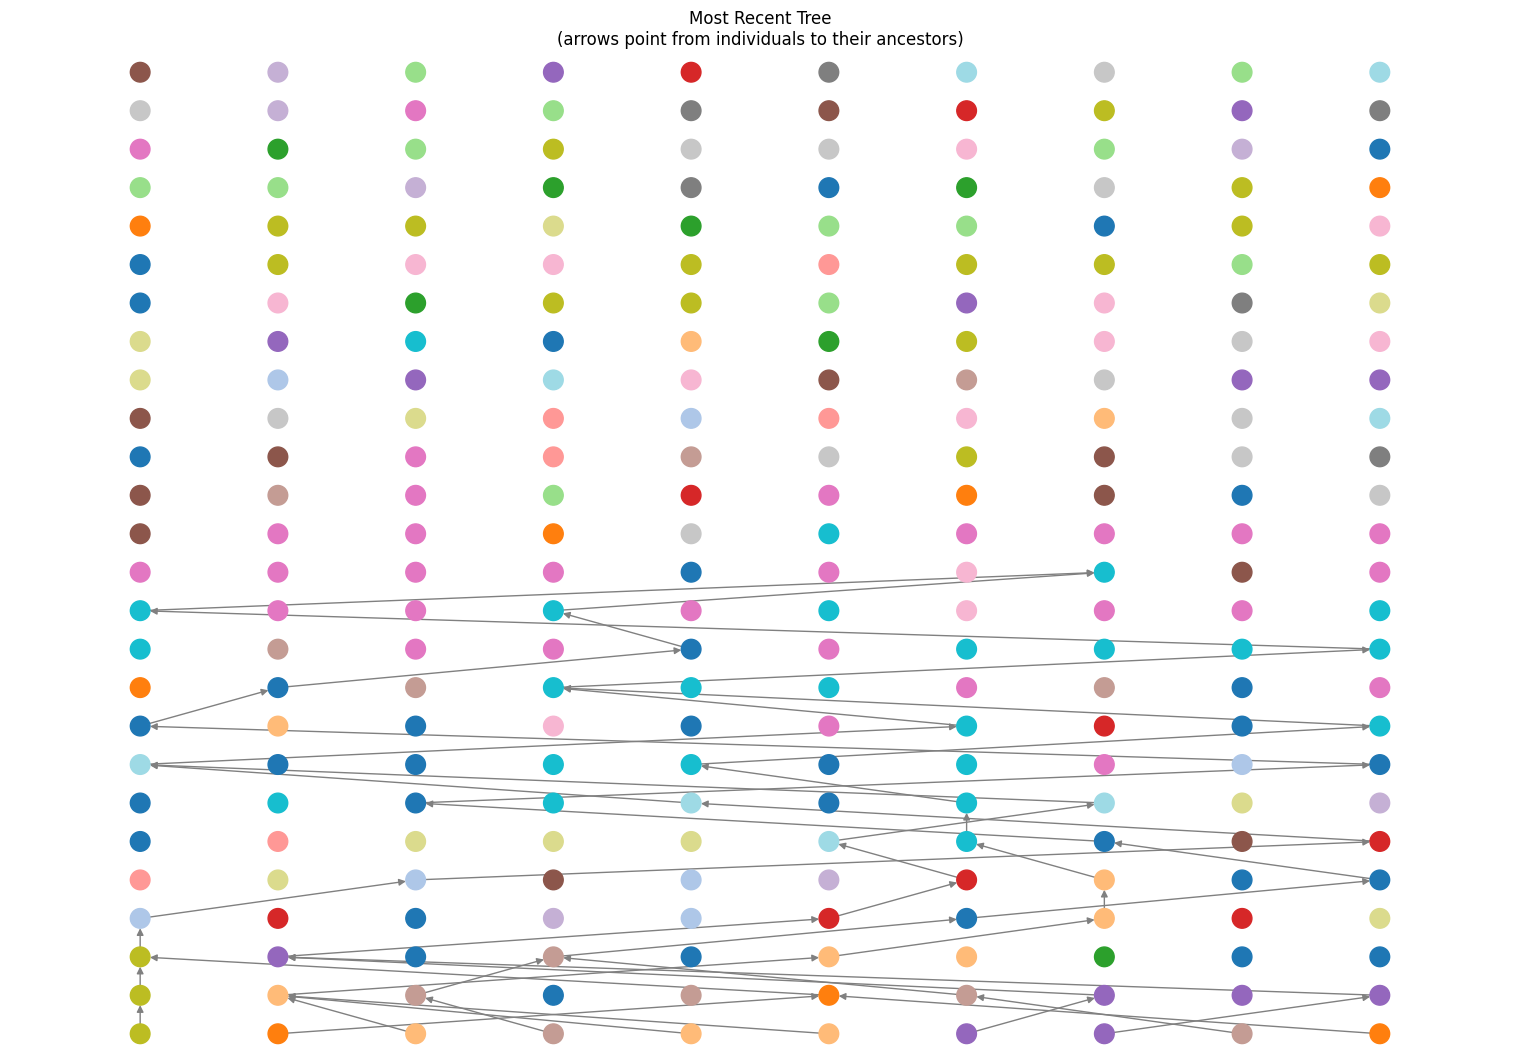

In [46]:

# Graph of population to trace most recent common ancestor
G = nx.DiGraph()

# Add edges only for chosen individual(s) in current generation
# individual_idxs = [0, 8]
# individual_idxs = [0]
individual_idxs = [i for i in range(len(my_pop.individuals))]

# Check and change limits for how far back nodes or edges are plotted
# gen_limit = mrca_individual.generation
gen_limit = 0
edge_limit = mrca_individual.generation

# Add nodes for all individuals in all generations
positions = {}
node_colors = {}
for gen_idx, generation in reversed(list(enumerate(my_pop.generations))):
    if gen_idx < gen_limit:
        break
    y_pos = -gen_idx  # Negative to have first generation at top
    for ind_idx, individual in enumerate(generation):
        # Use individual's ID as node identifier
        node_id = individual.id
        G.add_node(node_id)
        # Position nodes in a row for each generation
        x_pos = (ind_idx - len(generation)/2) / len(generation)  # Center individuals horizontally
        positions[node_id] = (x_pos, y_pos)
        node_colors[individual.id] = genome_color_dict.get(individual.genome, 'black')


for individual_idx in individual_idxs:
    individual = my_pop.individuals[individual_idx]
    if hasattr(individual, 'parent'):
        while individual.parent is not None and individual.parent.generation >= edge_limit:
            G.add_edge(individual.id, individual.parent.id)
            individual = individual.parent

colors  = [node_colors.get(node, 'gray') for node in G.nodes()]

# Create the plot
plt.figure(figsize=(15, 10))
nx.draw(G, pos=positions, 
        node_size=200,
        node_color=colors,
        edge_color='gray',
        arrowsize=10,
        with_labels=False)

# Add generation labels on the y-axis
plt.ylim(-(len(my_pop.generations)-0.5), 0.5-gen_limit)
plt.title('Most Recent Tree\n(arrows point from individuals to their ancestors)')
plt.show()

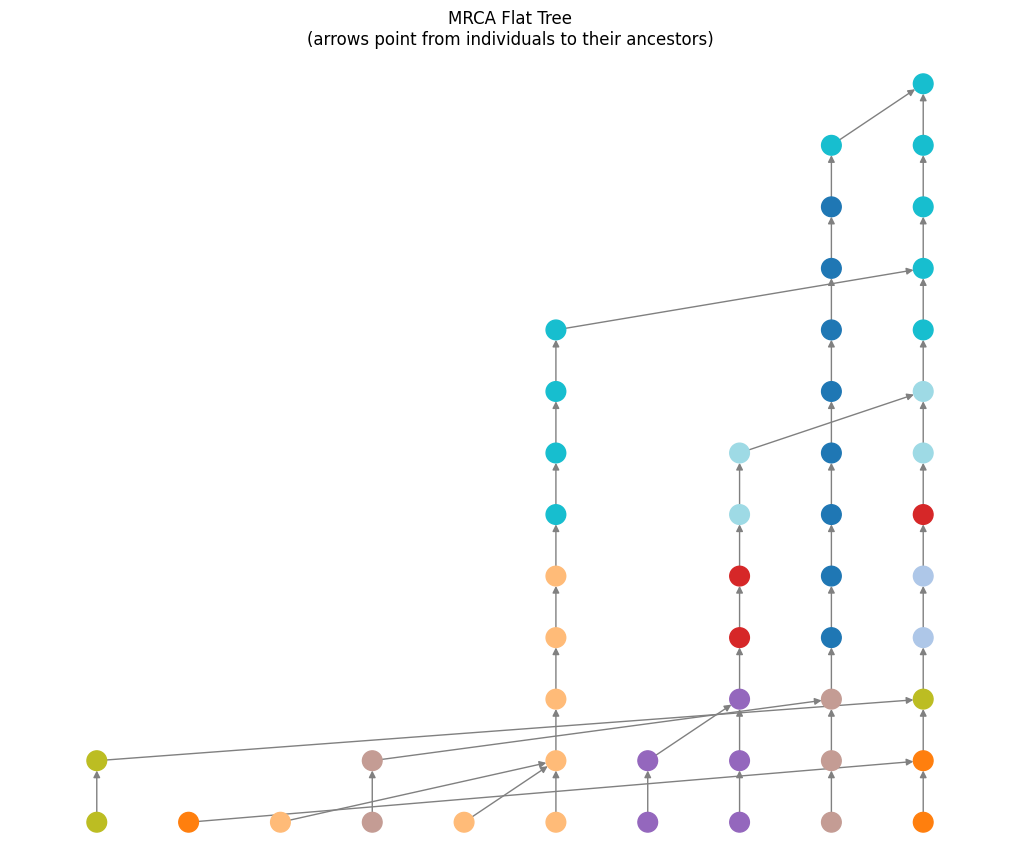

In [47]:
# Flat raph of population to trace most recent common ancestor
G = nx.DiGraph()

# Add edges only for chosen individual(s) in current generation
# individual_idxs = [0, 8]
individual_idxs = [i for i in range(len(my_pop.individuals))]
gen_limit = mrca_individual.generation
# individual_idxs = [0]

# Store node colors
node_colors = {}

positions = {}
x_pos_offset = {-g: x for g in range(len(my_pop.generations)) for x in np.zeros(len(my_pop.generations[g]))}
for individual_idx in individual_idxs:
    individual = my_pop.individuals[individual_idx]
    # Some duplicate code to add node
    if not G.has_node(individual.id):
        G.add_node(individual.id)
    generation = my_pop.generations[individual.generation]
    y_pos = -individual.generation  # Negative to have first generation at top
    x_pos = (x_pos_offset[y_pos] - len(generation)/2) / len(generation) 
    x_pos_offset[y_pos] += 1
    positions[individual.id] = (x_pos, y_pos)
    node_colors[individual.id] = genome_color_dict.get(individual.genome, 'gray')
    if hasattr(individual, 'parent'):
        while individual.parent is not None and individual.parent.generation >= gen_limit:
            orig_id = individual.id
            individual = individual.parent
            if not G.has_node(individual.id):
                G.add_node(individual.id)
            generation = my_pop.generations[individual.generation]
            y_pos = -individual.generation  # Negative to have first generation at top
            x_pos = (x_pos_offset[y_pos] - len(generation)/2) / len(generation) 
            x_pos_offset[y_pos] += 1
            positions[individual.id] = (x_pos, y_pos)
            node_colors[individual.id] = genome_color_dict.get(individual.genome, 'black')
            G.add_edge(orig_id, individual.id)

colors = [node_colors.get(node, 'gray') for node in G.nodes()]

# Create the plot
plt.figure(figsize=(10, 8))
nx.draw(G, pos=positions, 
        node_size=200,
        node_color=colors,
        edge_color='gray',
        arrowsize=10,
        with_labels=False)

# Add generation labels on the y-axis
plt.ylim(-(len(my_pop.generations)-0.5), 0.5-gen_limit)
plt.title('MRCA Flat Tree\n(arrows point from individuals to their ancestors)')
plt.show()

In [48]:
del positions, x_pos, y_pos

Total nodes: 50
Positioned nodes: 50
Unique genomes: 83
Unpositioned nodes: set()


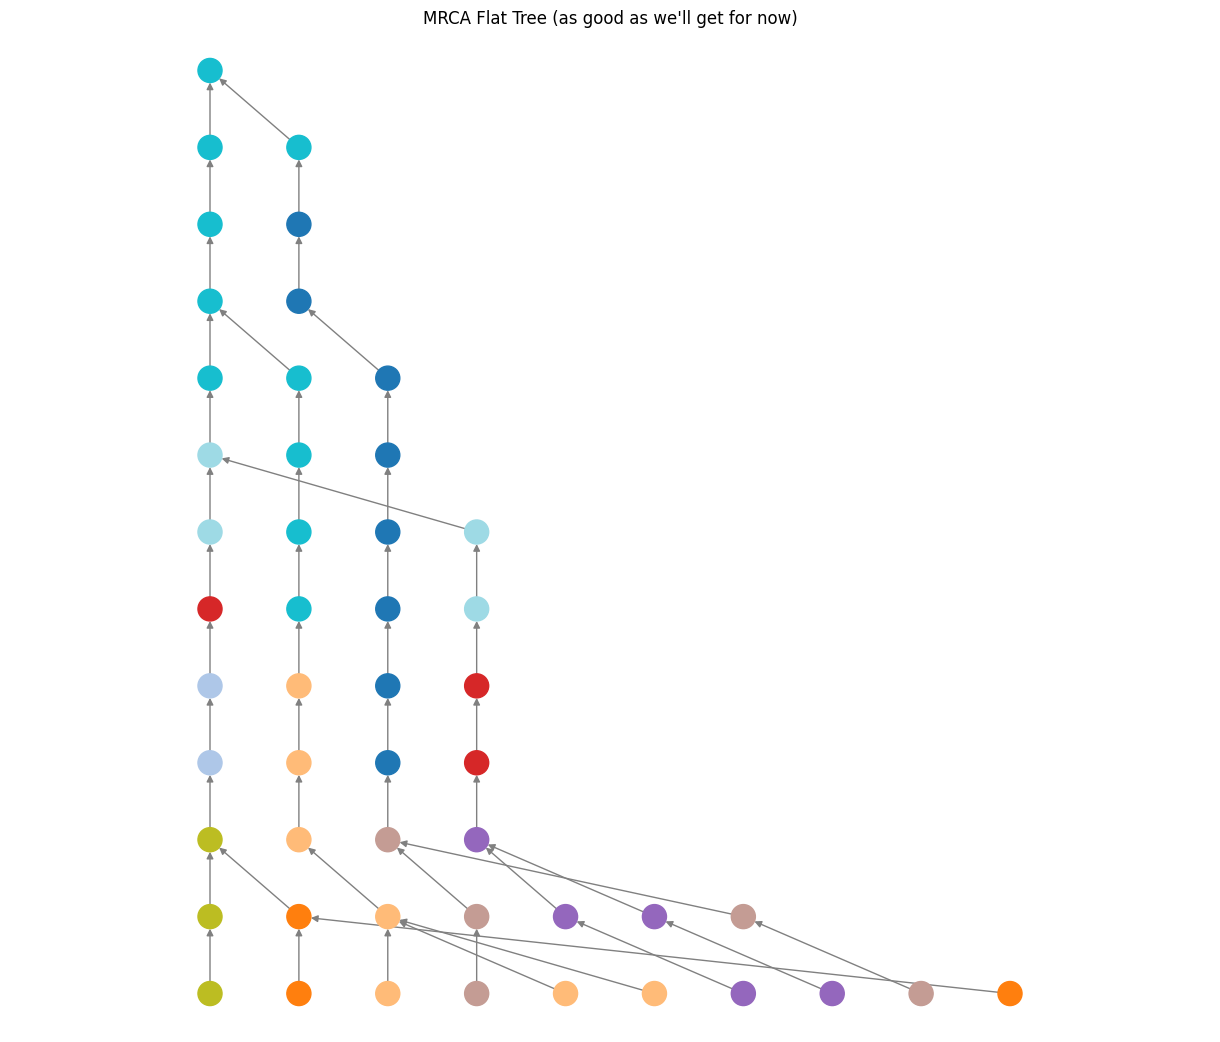

In [49]:
G = nx.DiGraph()

individual_idxs = [i for i in range(len(my_pop.individuals))]
gen_limit = mrca_individual.generation
# individual_idxs = [0]

# Store positions of nodes
positions = {}

# Store node colors
node_colors = {}

# Track positioning within each generation to ensure unique placements
gen_node_counts = {g: 0 for g in range(len(my_pop.generations))}

# Now generated in above section
# unique_genomes = list(set(ind.genome for ind in my_pop.individuals))
# color_map = plt.cm.get_cmap('tab20')  # Use tab20 for up to 20 distinct colors
# genome_color_dict = {genome: color_map(i/len(unique_genomes)) 
#                         for i, genome in enumerate(unique_genomes)}

# Process each specified individual
for individual_idx in individual_idxs:
    individual = my_pop.individuals[individual_idx]
    
    # Trace full lineage, including the initial individual
    current = individual
    while current is not None and current.generation >= gen_limit:
        # Ensure node is added if not already in graph
        if not G.has_node(current.id):
            # Calculate centered x-position for the generation
            generation = my_pop.generations[current.generation]
            gen_width = len(generation)
            
            # Compute x position to center the generation
            if gen_width == 1:
                x_pos = 0  # Center for single node generations
            else:
                # Use the tracking count to distribute nodes
                gen_node_count = gen_node_counts[current.generation]
                x_pos = ((gen_node_count - (gen_width - 1) / 2) / 
                            ((gen_width - 1) / 2 if gen_width > 1 else 1))
                
                # Increment the node count for this generation
                gen_node_counts[current.generation] += 1
            
            # Set y position (negative to have first generation at top)
            y_pos = -current.generation
            positions[current.id] = (x_pos, y_pos)
            # Assign color based on genome
            node_colors[current.id] = genome_color_dict.get(current.genome, 'black')
            G.add_node(current.id)
        
        # Add edge to parent if exists
        if hasattr(current, 'parent') and current.parent is not None and current.parent.generation >= gen_limit:
            # Ensure parent is also added
            if not G.has_node(current.parent.id):
                # Recursively ensure parent gets a position
                generation = my_pop.generations[current.parent.generation]
                gen_width = len(generation)
                
                if gen_width == 1:
                    x_pos = 0
                else:
                    gen_node_count = gen_node_counts[current.parent.generation]
                    x_pos = ((gen_node_count - (gen_width - 1) / 2) / 
                                ((gen_width - 1) / 2 if gen_width > 1 else 1))
                    gen_node_counts[current.parent.generation] += 1
                
                y_pos = -current.parent.generation
                positions[current.parent.id] = (x_pos, y_pos)
                # Assign color for parent
                node_colors[current.parent.id] = genome_color_dict.get(current.parent.genome, 'gray')
                G.add_node(current.parent.id)
            
            # Add edge
            G.add_edge(current.id, current.parent.id)
            current = current.parent
        else:
            break

# Diagnostic print to verify all intended nodes are positioned
print(f"Total nodes: {len(G.nodes())}")
print(f"Positioned nodes: {len(positions)}")
print(f"Unique genomes: {len(unique_genomes)}")
print(f"Unpositioned nodes: {set(G.nodes()) - set(positions.keys())}")


plt.figure(figsize=(12, 10))

# Extract color list in the same order as nodes
colors = [node_colors.get(node, 'gray') for node in G.nodes()]

# Draw the graph
nx.draw(G, 
        pos=positions, 
        node_size=300,
        node_color=colors,
        edge_color='gray',
        arrowsize=10,
        with_labels=False)

# Adjust plot limits
x_vals = [pos[0] for pos in positions.values()]
y_vals = [pos[1] for pos in positions.values()]
plt.xlim(min(x_vals) - 0.5, max(x_vals) + 0.5)
plt.ylim(min(y_vals) - 0.5, max(y_vals) + 0.5)
# plt.yticks(np.arange(min(y_vals), max(y_vals)+1, 1), labels=range(0, len(my_pop.generations)))

plt.title('MRCA Flat Tree (as good as we\'ll get for now)')
# plt.tight_layout()
plt.show()


singly linked list up, inverted tree
BFS -> align sibling nodes, stack?
stack generations
loop individuals
add children and parent:
    if left and right, stagger space
    if left xor right, center
    spacer to end, save spacer for parent row
    spacer must affect parents & children, loop down to adjust
loop children-parent

In [50]:
# %history -g -f "notebooks/notebook_hist.txt" # Save history to file

In [ ]:
# Define population sizes to analyze
# sizes = [5, 10, 20, 30, 40, 50, 60, 70, 90, 100, 200, 300, 400, 500]
# sizes = [50, 100, 200, 300, 400, 500]
sizes = [i for i in range(5,106,20)]
simulation_reps = 2000
# Run analysis
means, results = my_pop.analyze_population_size_vs_mrca_time(sizes, repetitions=simulation_reps)

In [17]:
for size, avg_time in means.items():
    print(f"Population Size {size}: Average TMRCA = {avg_time:.2f} generations, all: {results[size]}")

Population Size 5: Average TMRCA = 7.45 generations, all: [5, 15, 17, 5, 15, 10, 3, 25, 8, 9, 12, 24, 6, 5, 5, 2, 6, 7, 4, 7, 3, 5, 8, 9, 6, 2, 5, 6, 10, 5, 8, 8, 4, 6, 13, 13, 8, 3, 12, 14, 6, 7, 8, 6, 10, 16, 5, 7, 6, 5, 7, 4, 10, 15, 6, 3, 3, 2, 5, 2, 5, 5, 9, 8, 11, 5, 15, 4, 4, 6, 9, 6, 3, 9, 8, 3, 7, 4, 8, 10, 15, 3, 5, 12, 6, 10, 3, 5, 8, 10, 13, 7, 10, 7, 10, 12, 3, 5, 7, 13, 9, 4, 7, 5, 13, 3, 21, 15, 5, 7, 17, 8, 5, 5, 24, 4, 7, 3, 11, 5, 4, 7, 3, 2, 8, 20, 12, 21, 6, 8, 3, 19, 8, 5, 6, 6, 4, 12, 5, 3, 6, 4, 4, 6, 2, 3, 10, 24, 16, 3, 17, 5, 7, 13, 8, 5, 12, 5, 11, 3, 3, 13, 6, 15, 2, 5, 4, 5, 10, 8, 7, 6, 8, 8, 8, 4, 11, 9, 9, 8, 8, 4, 6, 4, 7, 4, 7, 3, 6, 3, 12, 8, 8, 15, 9, 8, 6, 6, 7, 6, 16, 13, 5, 4, 5, 5, 4, 5, 4, 5, 6, 8, 9, 13, 4, 3, 25, 6, 5, 8, 2, 7, 4, 8, 5, 7, 4, 9, 4, 3, 6, 6, 4, 17, 5, 9, 7, 4, 3, 4, 8, 6, 5, 6, 4, 9, 3, 8, 8, 6, 7, 17, 16, 6, 7, 3, 7, 11, 8, 2, 2, 11, 13, 8, 7, 5, 5, 8, 3, 8, 3, 8, 6, 8, 14, 8, 4, 6, 10, 20, 4, 19, 16, 4, 17, 2, 7, 12, 12, 9, 1

In [ ]:
# Report non-convergence
for size, vals in results.items():
    if len(vals) < simulation_reps:
        print(f"Population Size {size} did not converge for {simulation_reps - len(vals)} repetitions\n")
    else:
        print(f"Population {size} converged for all repetitions")

Population Size 5: Did not converge for 16 repetitions

Population Size 25: Did not converge for 41 repetitions

Population Size 45: Did not converge for 38 repetitions

Population Size 65: Did not converge for 36 repetitions

Population Size 85: Did not converge for 51 repetitions

All population sizes converged for all repetitions


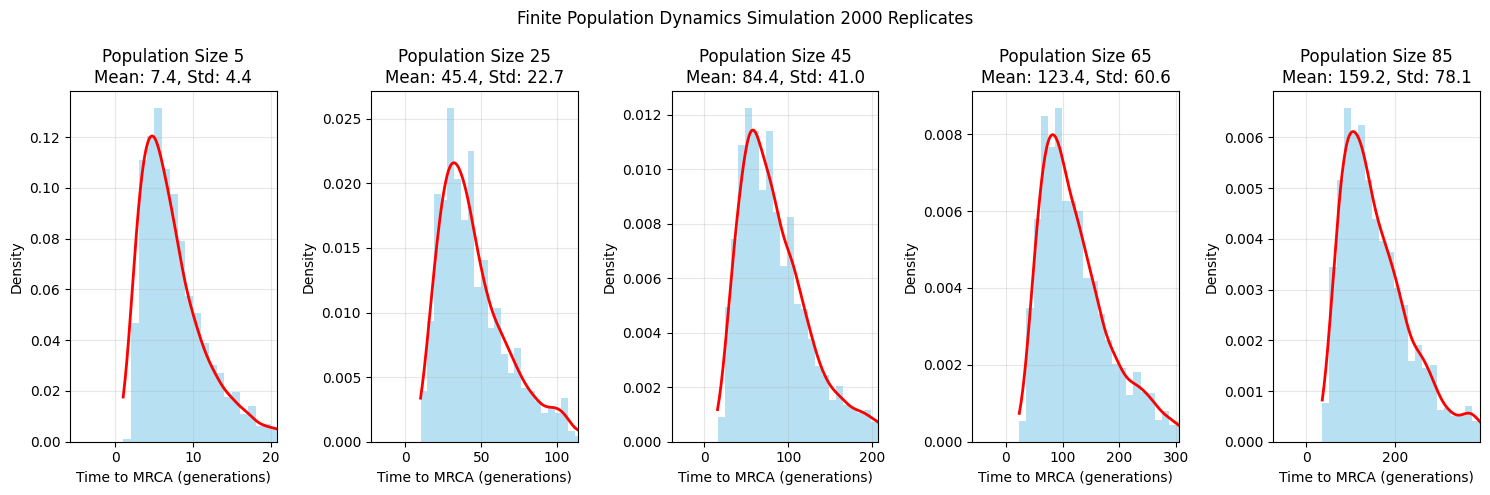

In [ ]:
# Create subplots for each population size
r = 1
c = len(results)
fig, axes = plt.subplots(r, c, figsize=(15, 5))
if len(results) == 1:
    axes = [axes]

for ax, (size, vals) in zip(axes, results.items()):

    mean = np.mean(vals)
    std = np.std(vals)
    # Create histogram
    ax.hist(vals, bins='auto', density=True, alpha=0.6, color='skyblue')
    ax.set_xlim([mean-3*std, mean+3*std])
    
    # Calculate KDE
    kde = stats.gaussian_kde(vals)  # just leave auto kernel size as changes for each dist
    x_range = np.linspace(min(vals), max(vals), 200)
    ax.plot(x_range, kde(x_range), 'r-', lw=2)
    
    ax.set_xlabel('Time to MRCA (generations)')
    ax.set_ylabel('Density')
    ax.set_title(f'Population Size {size}\n'
                 f'Mean: {mean:.1f}, Std: {std:.1f}')
    ax.grid(True, alpha=0.3)

plt.suptitle(f"Finite Population Dynamics Simulation {simulation_reps} Replicates")
plt.tight_layout()
plt.show()

# Looks like E[TMRCA] converges to N, s to 0.5N, should be 2N and N

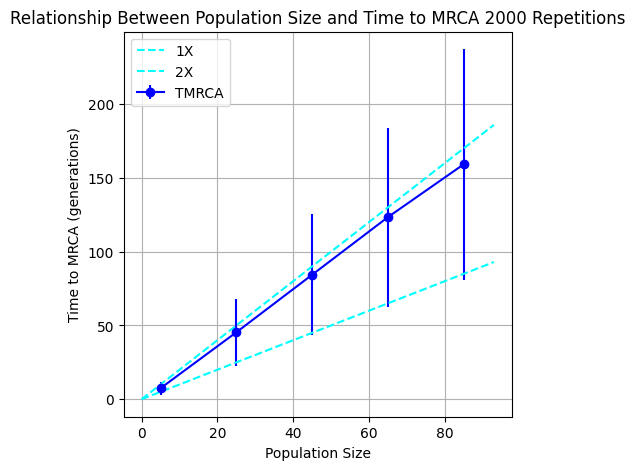

In [20]:
# Plot MRCA
fig, ax = plt.subplots(figsize=(5, 5))

sizes = list(means.keys())
times = [means[size] for size in sizes]
errs = [np.std(results[size]) for size in sizes]
max_size = max(sizes)
offset = round(max_size/10)

# Plot 1x and 2x line, simulation means/results
ax.errorbar(sizes, times, yerr=errs, fmt='o-', color='blue')
ax.plot([0, max_size+offset], [0,max_size+offset], '--', color='cyan')
ax.plot([0, max_size+offset], [0,max_size*2+2*offset], '--', color='cyan')
ax.set_xlabel('Population Size')
ax.set_ylabel('Time to MRCA (generations)')
ax.set_title(f'Relationship Between Population Size and Time to MRCA {simulation_reps:0.0f} Repetitions')
ax.grid(True)
ax.legend(["1X", "2X","TMRCA"], loc='upper left')
plt.show()